# Import the necessary libraries

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer

from joblib import load

import seaborn as sns

# Import train & test data

In [62]:
# Define the undersampling method and ratio (50:50, 40:60, 70:30)
# Options: 'RandomUnderSampler_50_50', 'ClusterCentroids_40_60', 'NearMiss_30_70', etc.
# Example: 'RandomUnderSampler_30_70' applies RandomUnderSampler with a 30:70 direct-to-indirect ratio
rs_type = 'NearMiss_50_50'

# Load training dataset
# X_train: Feature matrix (input variables)
# y_train: Target labels (output variable)
X_train = pd.read_csv('./Data/Undersampling/X_train_'+ rs_type +'.csv')
y_train = pd.read_csv('./Data/Undersampling/y_train_' + rs_type + ".csv")

# X_test: Feature matrix for testing
# y_test: Target labels for testing
X_test = pd.read_csv('./Data/X_test.csv')
y_test = pd.read_csv('./Data/y_test.csv')

# Drop unecessaries columns
X_test = X_test.drop(columns=['mp_id_bg', 'formula', 'symmetry'])

In [63]:
# Define output filename prefix for saved results
outname = rs_type

# Load trained model

In [64]:
RF = load('./Trained model/RF_'+rs_type+'.joblib') 
XGB = load('./Trained model/XGB_'+rs_type+'.joblib') 

## RF classification report

In [65]:
print('RF')

# Retrieve the best cross-validation F1-score from the trained RF model
f1_scorer = make_scorer(f1_score)
cv_rf = cross_val_score(RF, X_train, y_train.values.ravel(), cv=5, n_jobs=-1, scoring=f1_scorer)

print("Cross Validation Scores:", cv_rf)
print("Mean CV F1:", cv_rf.mean())

# Make predictions on test data
y_pred_rf = RF.predict(X_test)

# Make predictions on test data
print('TEST!')
print(classification_report(y_test, y_pred_rf))

RF
Cross Validation Scores: [0.75806452 0.87906977 0.83568075 0.83333333 0.80962801]
Mean CV F1: 0.823155275366134
TEST!
              precision    recall  f1-score   support

       False       0.93      0.52      0.67       840
        True       0.38      0.88      0.53       274

    accuracy                           0.61      1114
   macro avg       0.65      0.70      0.60      1114
weighted avg       0.79      0.61      0.63      1114



## XGB classification report

In [66]:
print('XGB')

# Retrieve the best cross-validation F1-score from the trained XGB model
f1_scorer = make_scorer(f1_score)
cv_xgb = cross_val_score(XGB, X_train, y_train.values.ravel(), cv=5, n_jobs=-1, scoring=f1_scorer)

print("Cross Validation Scores:", cv_xgb)
print("Mean CV F1:", cv_xgb.mean())

# Make predictions on test data
y_pred_xgb = XGB.predict(X_test)

# Print classification report for XGB
print('TEST!')
print(classification_report(y_test, y_pred_xgb))

XGB
Cross Validation Scores: [0.7505071  0.87414188 0.83886256 0.81304348 0.81497797]
Mean CV F1: 0.8183065973785089
TEST!
              precision    recall  f1-score   support

       False       0.92      0.52      0.66       840
        True       0.37      0.86      0.51       274

    accuracy                           0.60      1114
   macro avg       0.64      0.69      0.59      1114
weighted avg       0.78      0.60      0.62      1114



# Evaluation

In [67]:
# Function to evaluate model performance using precision, recall, and F1-score
def eval_score(y_test, y_pred):

    precision_avg = precision_score(y_test, y_pred)
    recall_avg = recall_score(y_test, y_pred)
    f1_avg = f1_score(y_test, y_pred)
    return precision_avg, recall_avg, f1_avg

In [68]:
# Store cross-validation results
df_cv = pd.DataFrame({'Metrics':'CV', 'RF':cv_rf.mean(), 
                      'XGB':cv_xgb.mean()}, index=[0])

# Compute test set evaluation metrics for both models
rf_score = eval_score(y_test, y_pred_rf)
xgb_score = eval_score(y_test, y_pred_xgb)

# Create a DataFrame to store precision, recall, and F1-score for both models
metrics_name = ['Precission', 'Recall', 'F1']
df_score = pd.DataFrame({'Metrics':metrics_name, 'RF':rf_score, 'XGB':xgb_score})

# Combine cross-validation and test evaluation results
df_eval = pd.concat([df_cv,df_score])

df_eval.to_csv('./Result/Eval_'+ rs_type + '.csv', index=False)
df_eval

,Metrics,RF,XGB
0,CV,0.823155,0.818307
0,Precission,0.375389,0.367030
1,Recall,0.879562,0.861314
2,F1,0.526201,0.514722


## Plot confusion matrix

### RF

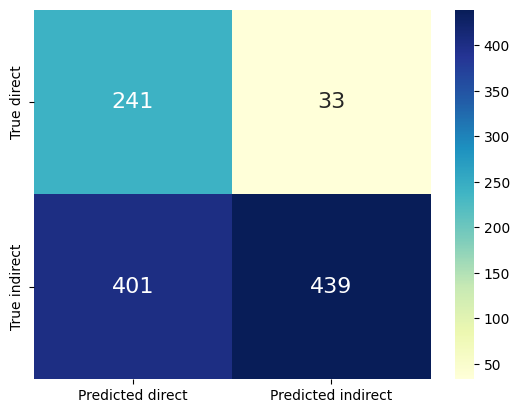

In [69]:
# Plot confusion matrix for RF
cm_rf =sns.heatmap(confusion_matrix(y_test, y_pred_rf, labels=[True,False]),cmap='YlGnBu',
                      fmt = '.0f', 
                      annot=True, annot_kws={"size": 16},
                      xticklabels=['Predicted direct','Predicted indirect'],
                      yticklabels=['True direct','True indirect'])

# Save confusion matrix for RF
plt.savefig('./Result/'+ outname +'_cm_rf.png', dpi=300)
plt.show()

### XGB

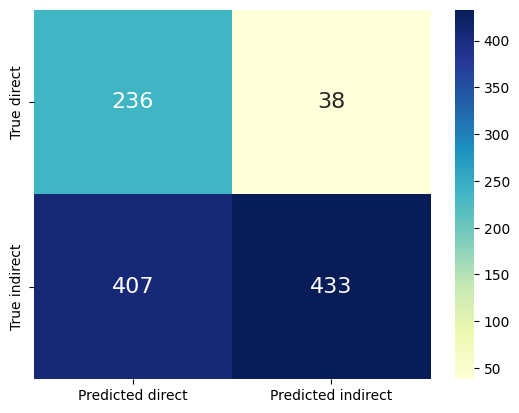

In [70]:
# Plot confusion matrix for XGB
cm_xgb =sns.heatmap(confusion_matrix(y_test, y_pred_xgb, labels=[True,False]),cmap='YlGnBu',
                      fmt = '.0f', 
                      annot=True, annot_kws={"size": 16},
                      xticklabels=['Predicted direct','Predicted indirect'],
                      yticklabels=['True direct','True indirect'])

# Save confusion matrix for XGB
plt.savefig('./Result/'+ outname +'_cm_xgb.png', dpi=300)
plt.show()